# São Paulo Subway - EDA Passenger Transported Demand by line

from January 2017 to April 2023.

Import libaries

In [1]:
from matplotlib.style import use

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline
use('seaborn-v0_8')

Read CSV file.

In [2]:
PATH = 'Passenger-demand-by-line-Final-Version-02.csv'
df = pd.read_csv(PATH, index_col='year_month')

## Visualizations

[]

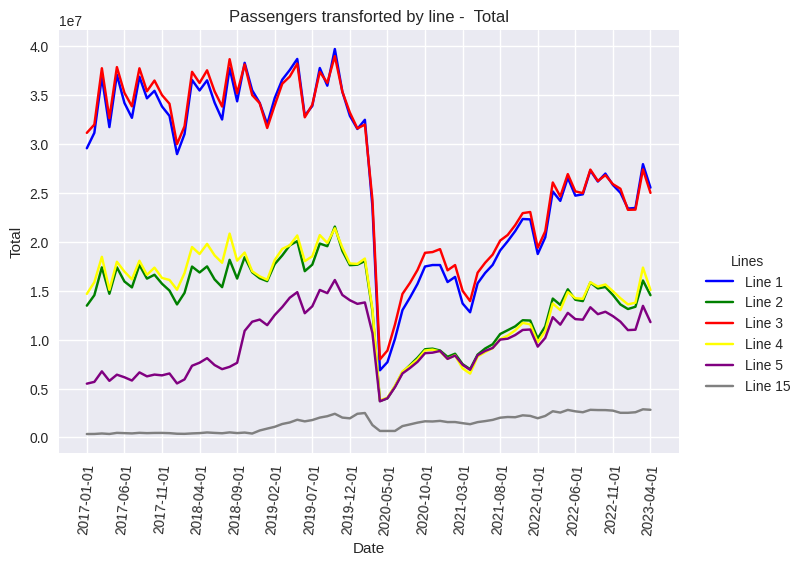

In [4]:
plt.plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'total'], label='Line 1', color='blue')
plt.plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'total'], label='Line 2', color='green')
plt.plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'total'], label='Line 3', color='red')
plt.plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'total'], label='Line 4', color='yellow')
plt.plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'total'], label='Line 5', color='purple')
plt.plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'total'], label='Line 15', color='gray')
plt.title('Passengers transforted by line -  Total')
plt.xlabel('Date')
plt.ylabel('Total')
plt.xticks(ticks=list(np.unique(df.index))[::5], rotation=85)
plt.legend(bbox_to_anchor=(0.7, 0., 0.5, 0.5), title='Lines')
plt.plot()

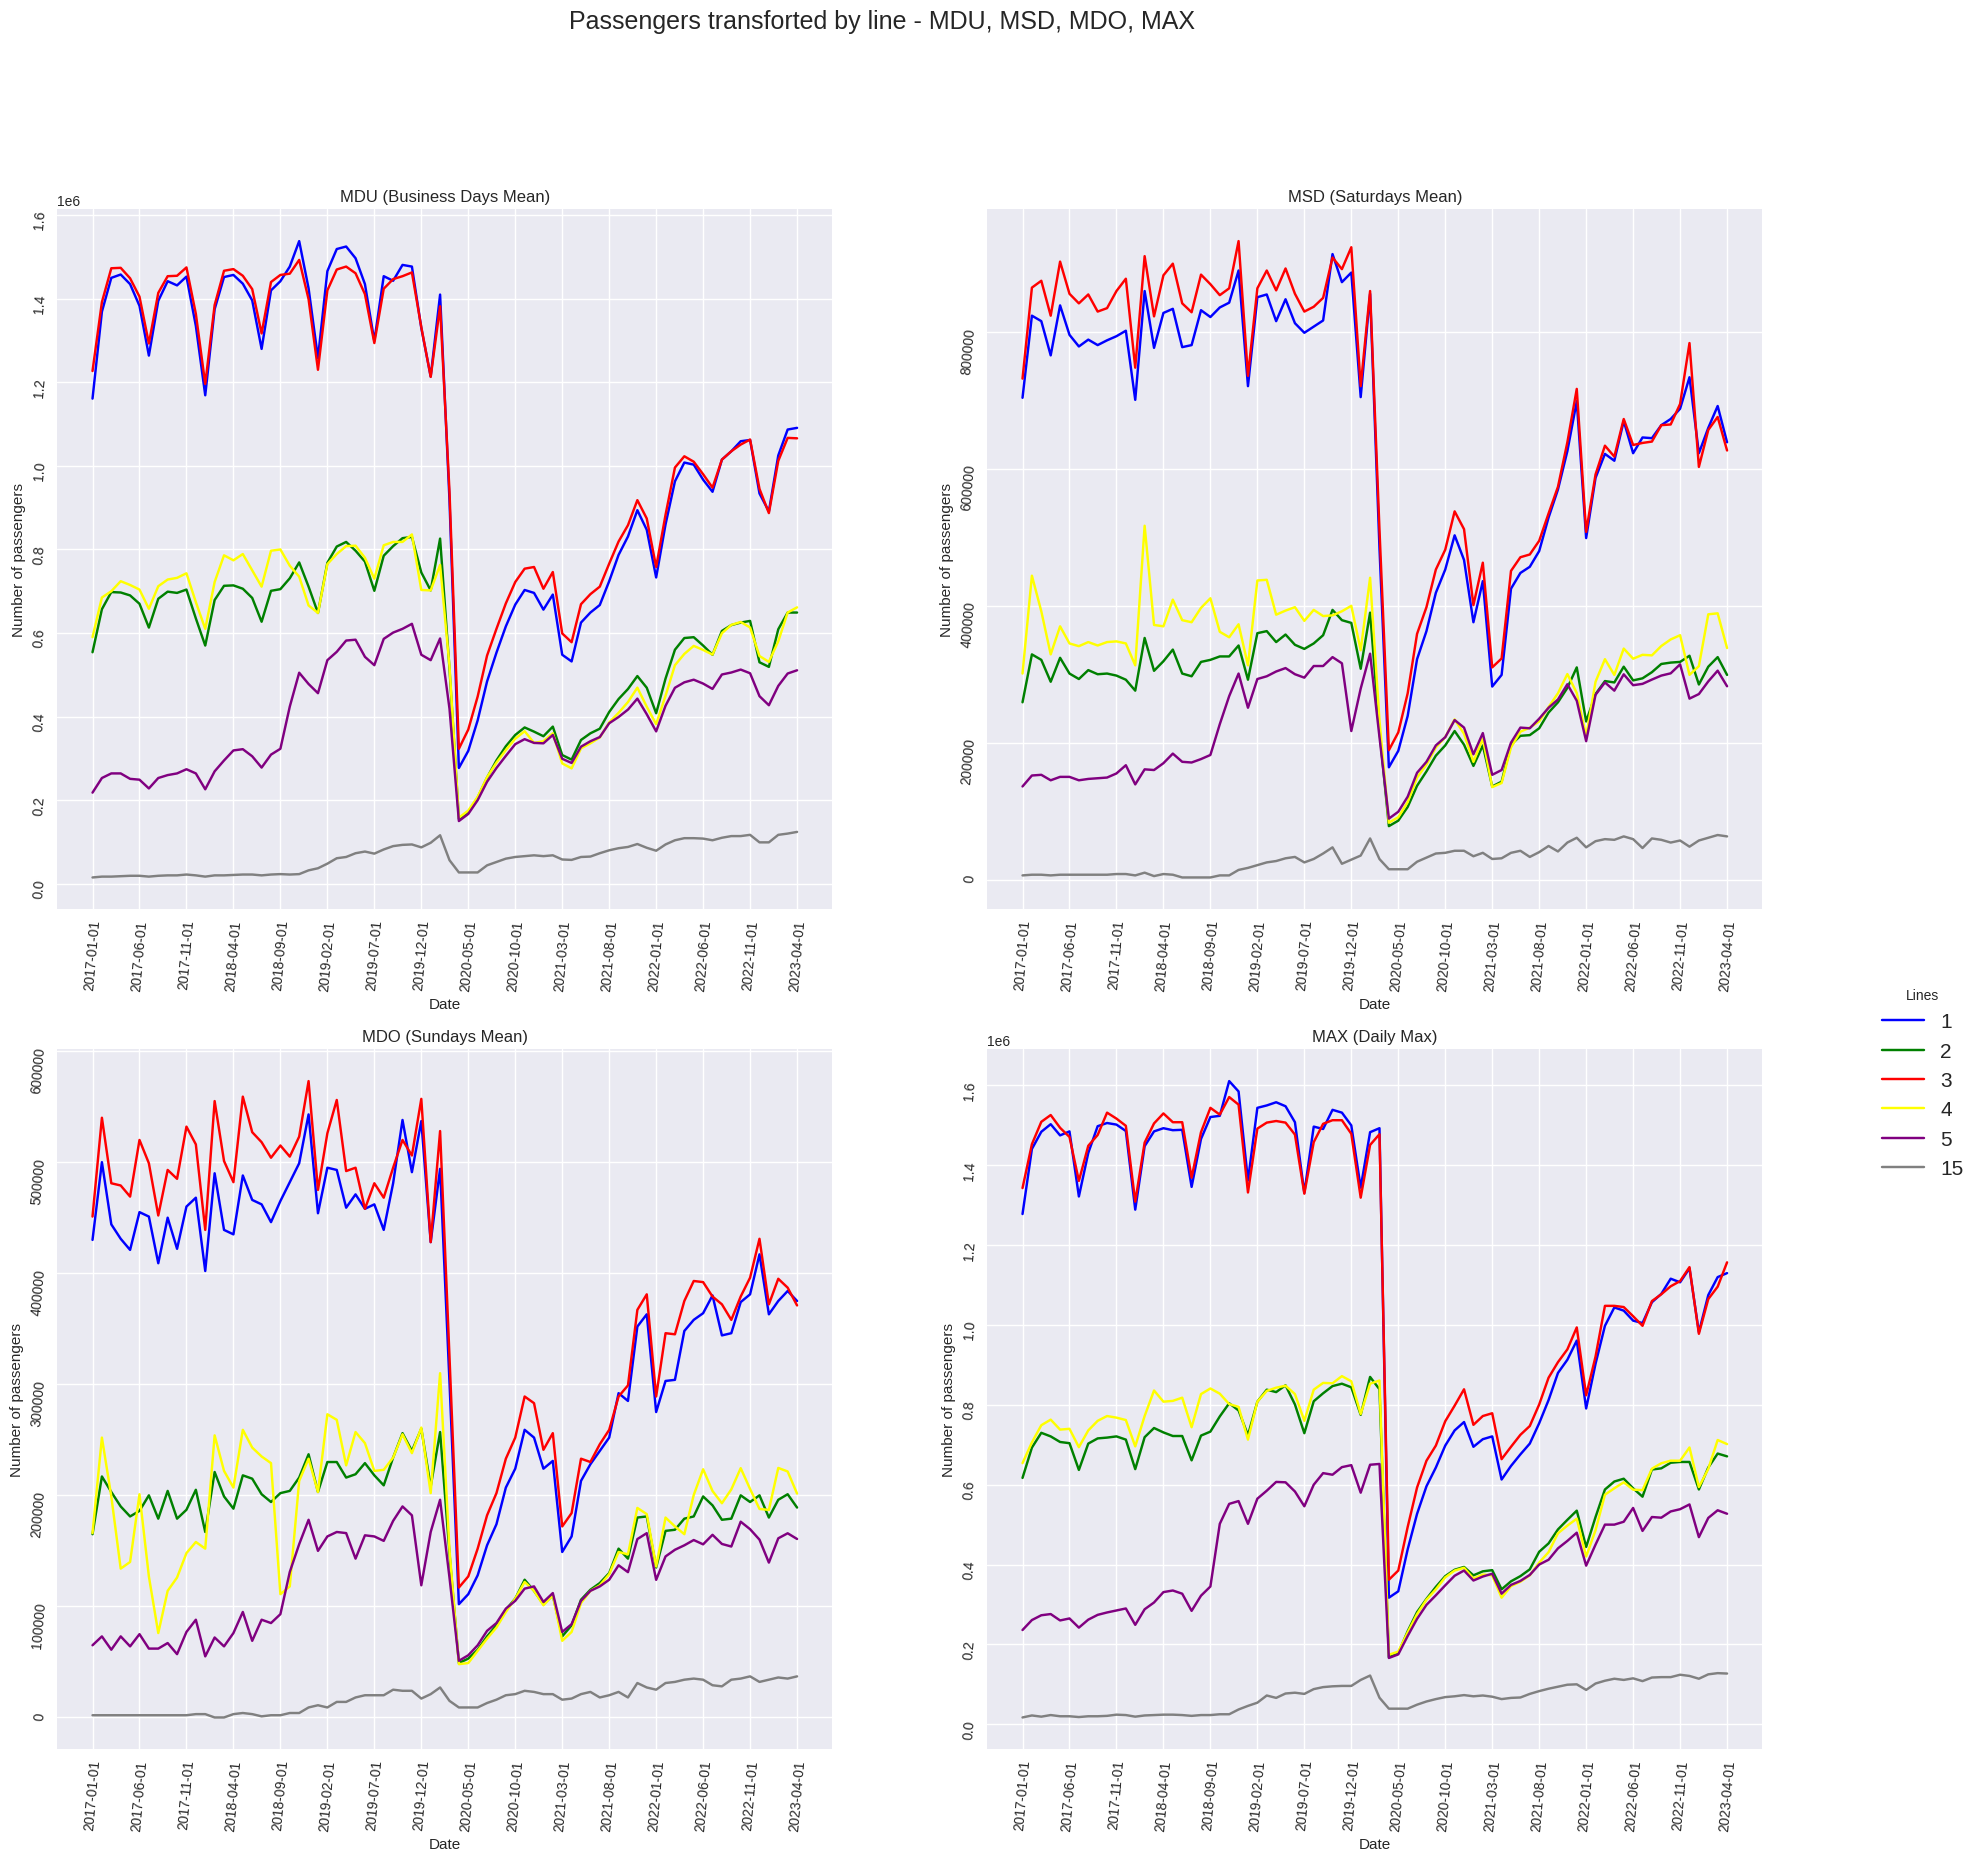

In [5]:
color_lines = {1: 'blue', 2: 'green', 3: 'red', 4: 'yellow', 5: 'purple', 15: 'gray'}

figure = plt.figure(figsize=(22, 20))
axs = figure.subplots(nrows=2, ncols=2)
figure.suptitle('Passengers transforted by line - MDU, MSD, MDO, MAX', fontsize=18)

axs[0][0].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MDU (Business Days Mean)'], label='Line 1', color=color_lines[1])
axs[0][0].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MDU (Business Days Mean)'], label='Line 2', color=color_lines[2])
axs[0][0].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MDU (Business Days Mean)'], label='Line 3', color=color_lines[3])
axs[0][0].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MDU (Business Days Mean)'], label='Line 4', color=color_lines[4])
axs[0][0].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MDU (Business Days Mean)'], label='Line 5', color=color_lines[5])
axs[0][0].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MDU (Business Days Mean)'], label='Line 15', color=color_lines[15])
axs[0][0].set_title('MDU (Business Days Mean)')
axs[0][0].set_xlabel('Date')
axs[0][0].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[0][0].tick_params(labelrotation=85)
axs[0][0].set_ylabel('Number of passengers')

axs[0][1].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MSD (Saturdays Mean)'], label='Line 1', color=color_lines[1])
axs[0][1].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MSD (Saturdays Mean)'], label='Line 2', color=color_lines[2])
axs[0][1].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MSD (Saturdays Mean)'], label='Line 3', color=color_lines[3])
axs[0][1].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MSD (Saturdays Mean)'], label='Line 4', color=color_lines[4])
axs[0][1].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MSD (Saturdays Mean)'], label='Line 5', color=color_lines[5])
axs[0][1].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MSD (Saturdays Mean)'], label='Line 15', color=color_lines[15])
axs[0][1].set_title('MSD (Saturdays Mean)')
axs[0][1].set_xlabel('Date')
axs[0][1].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[0][1].tick_params(labelrotation=85)
axs[0][1].set_ylabel('Number of passengers')

axs[1][0].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MDO (Sundays Mean)'], label='Line 1', color=color_lines[1])
axs[1][0].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MDO (Sundays Mean)'], label='Line 2', color=color_lines[2])
axs[1][0].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MDO (Sundays Mean)'], label='Line 3', color=color_lines[3])
axs[1][0].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MDO (Sundays Mean)'], label='Line 4', color=color_lines[4])
axs[1][0].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MDO (Sundays Mean)'], label='Line 5', color=color_lines[5])
axs[1][0].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MDO (Sundays Mean)'], label='Line 15', color=color_lines[15])
axs[1][0].set_title('MDO (Sundays Mean)')
axs[1][0].set_xlabel('Date')
axs[1][0].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[1][0].tick_params(labelrotation=85)
axs[1][0].set_ylabel('Number of passengers')

axs[1][1].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MAX (Daily Max)'], label='Line 1', color=color_lines[1])
axs[1][1].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MAX (Daily Max)'], label='Line 2', color=color_lines[2])
axs[1][1].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MAX (Daily Max)'], label='Line 3', color=color_lines[3])
axs[1][1].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MAX (Daily Max)'], label='Line 4', color=color_lines[4])
axs[1][1].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MAX (Daily Max)'], label='Line 5', color=color_lines[5])
axs[1][1].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MAX (Daily Max)'], label='Line 15', color=color_lines[15])
axs[1][1].set_title('MAX (Daily Max)')
axs[1][1].set_xlabel('Date')
axs[1][1].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[1][1].tick_params(labelrotation=85)
axs[1][1].set_ylabel('Number of passengers')

figure.legend(labels=color_lines.keys(),bbox_to_anchor=(0.5, 0., 0.5, 0.5), title='Lines', fontsize=15)
plt.show()

### Lines 1 and 3 participation in total of passenger transported demand by line

In [6]:
totals = df.groupby(by='year_month').sum().drop(labels='line', axis=1).loc[:,'total']

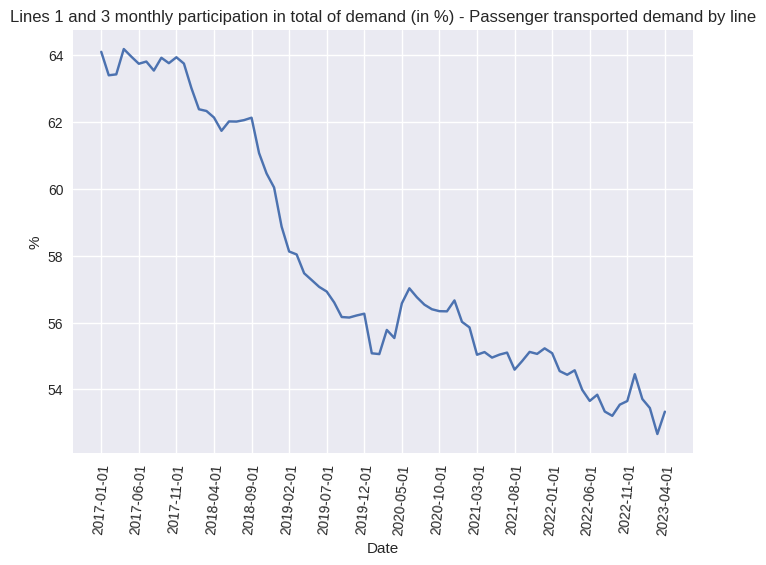

In [8]:
line_01_sum = df[df.loc[:,'line'] == 1].loc[:,'total']
line_03_sum = df[df.loc[:,'line'] == 3].loc[:,'total']
participation_line1_line2 = ((line_01_sum + line_03_sum) / totals) * 100

plt.plot(participation_line1_line2) 
plt.title('Lines 1 and 3 monthly participation in total of demand (in %) - Passenger transported demand by line')
plt.xlabel('Date')
plt.ylabel('%')
plt.xticks(ticks=list(np.unique(df.index))[::5], rotation=85)
plt.show()

#### Question:

If the monthly share of the two lines with the highest passenger demand is decreasing over time, is there any possibility that other lines are growing?

### The participation of each line in the total demand.

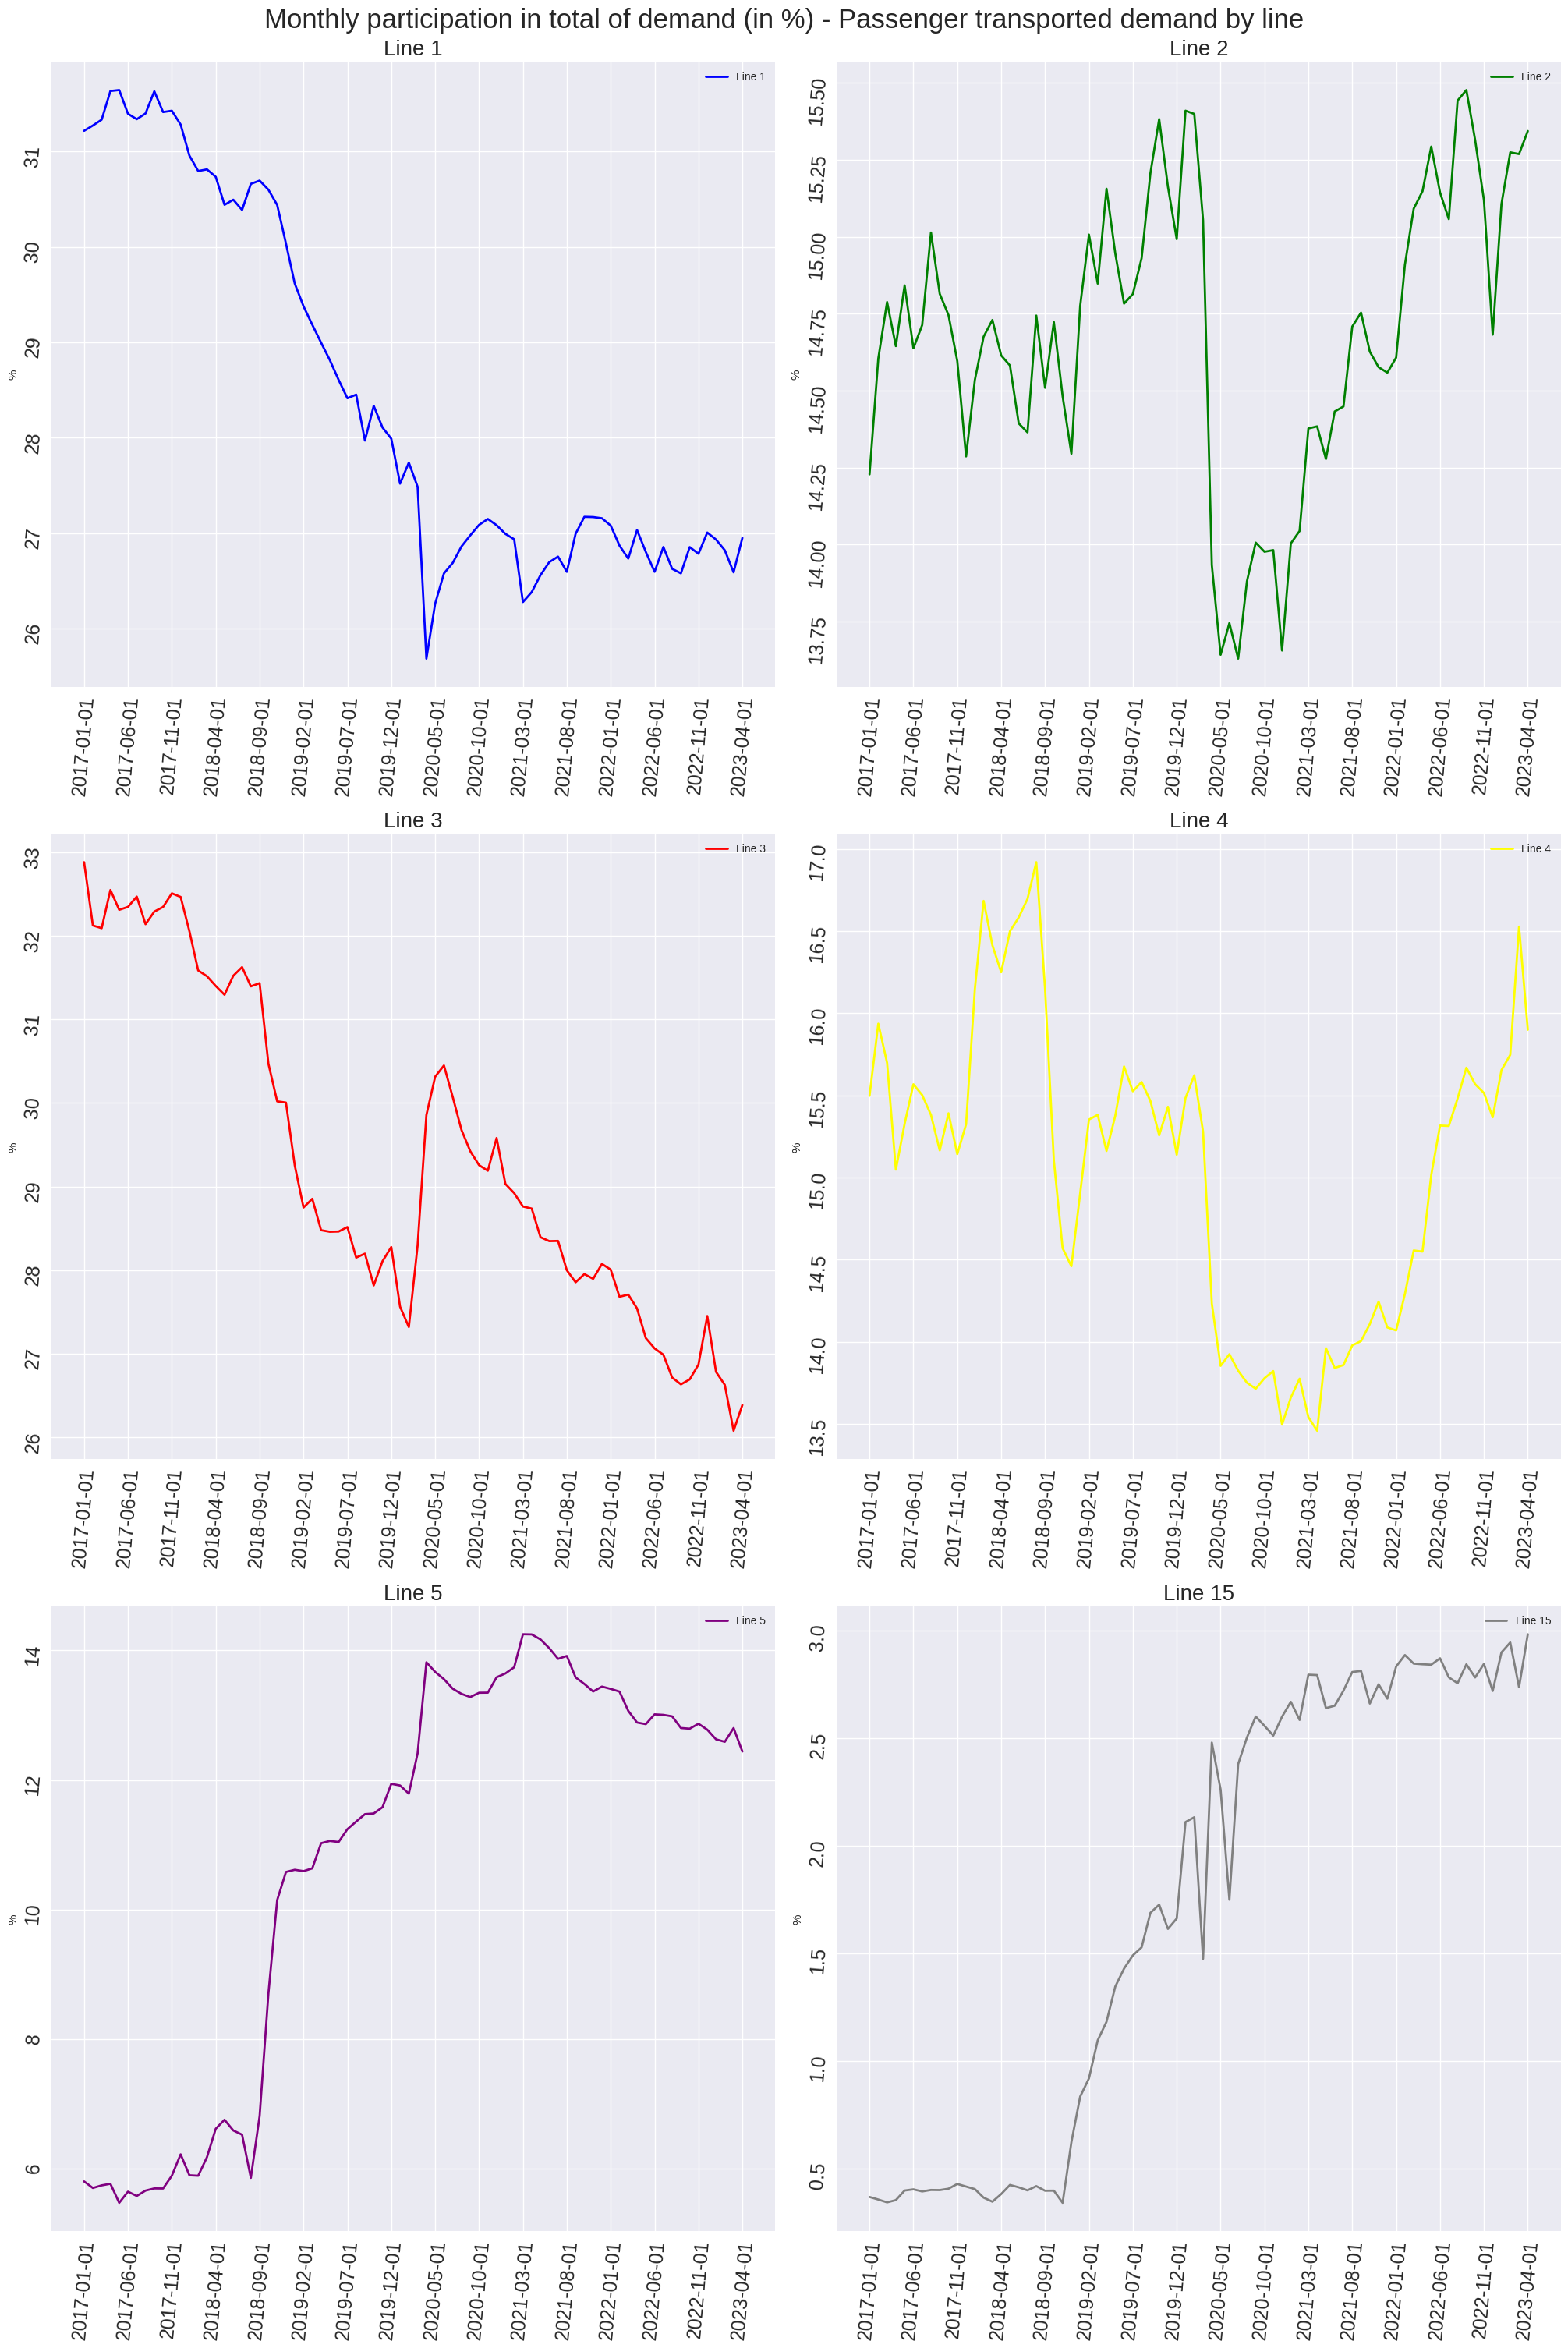

In [9]:
figure = plt.figure(figsize=(20, 30), layout='constrained')
axs = figure.subplots(nrows=3, ncols=2)

figure.suptitle('Monthly participation in total of demand (in %) - Passenger transported demand by line',
                fontsize=25)

line_01_sum = df[df.loc[:,'line'] == 1].loc[:,'total']
participation_line1 = (line_01_sum / totals) * 100
axs[0][0].plot(participation_line1, color=color_lines[1], label='Line 1', linewidth=2)
axs[0][0].set_title('Line 1', fontsize=20)
axs[0][0].set_ylabel('%')
axs[0][0].tick_params(labelrotation=85, labelsize=18)
axs[0][0].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[0][0].legend()

line_02_sum = df[df.loc[:,'line'] == 2].loc[:,'total']
participation_line2 = (line_02_sum / totals) * 100
axs[0][1].plot(participation_line2, color=color_lines[2], label='Line 2', linewidth=2)
axs[0][1].set_title('Line 2', fontsize=20)
axs[0][1].set_ylabel('%')
axs[0][1].tick_params(labelrotation=85, labelsize=18)
axs[0][1].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[0][1].legend()

line_03_sum = df[df.loc[:,'line'] == 3].loc[:,'total']
participation_line3 = (line_03_sum / totals) * 100
axs[1][0].plot(participation_line3, color=color_lines[3], label='Line 3', linewidth=2)
axs[1][0].set_title('Line 3', fontsize=20)
axs[1][0].set_ylabel('%')
axs[1][0].tick_params(labelrotation=85, labelsize=18)
axs[1][0].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[1][0].legend()

line_04_sum = df[df.loc[:,'line'] == 4].loc[:,'total']
participation_line4 = (line_04_sum / totals) * 100
axs[1][1].plot(participation_line4, color=color_lines[4], label='Line 4', linewidth=2)
axs[1][1].set_title('Line 4', fontsize=20)
axs[1][1].set_ylabel('%')
axs[1][1].tick_params(labelrotation=85, labelsize=18)
axs[1][1].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[1][1].legend()

line_05_sum = df[df.loc[:,'line'] == 5].loc[:,'total']
participation_line5 = (line_05_sum / totals) * 100
axs[2][0].plot(participation_line5, color=color_lines[5], label='Line 5', linewidth=2)
axs[2][0].set_title('Line 5', fontsize=20)
axs[2][0].set_ylabel('%')
axs[2][0].tick_params(labelrotation=85, labelsize=18)
axs[2][0].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[2][0].legend()

line_15_sum = df[df.loc[:,'line'] == 15].loc[:,'total']
participation_line15 = (line_15_sum / totals) * 100
axs[2][1].plot(participation_line15, color=color_lines[15], label='Line 15', linewidth=2)
axs[2][1].set_title('Line 15', fontsize=20)
axs[2][1].set_ylabel('%')
axs[2][1].tick_params(labelrotation=85, labelsize=18)
axs[2][1].set_xticks(ticks=list(np.unique(df.index))[::5])
axs[2][1].legend()

plt.show()

#### Questions:

<b>A.</b> What can be caused by participation decreases of demand in lines 1 and 3, are there significant changes in the infrastructure of the subway (new station or lines)?

<b>B.</b> What's the reason for the increasing in passenger transported demand in lines 5 and 15?

<b>C.</b> If the main lines are decreasing the demand, is there the possibility of other lines taking these positions in the next years?

<b>D.</b> Is this a new pattern or when the subway rescues the level of passenger demand near of previous COVID  pandemic the old pattern will return?

#### Answers:

<b>A.</b> 

<i>Line 1</i> - No changes

<i>Line 2</i> - No changes

<i>Line 3</i> - No changes

<i>Line 4</i> - 4 new station

| Station | Inauguration |
| - | - |
| São Paulo - Morumbi | December 27, 2018 |
| Higienópolis - Mackenzie | January 23, 2018 |
| Oscar Freire | April 4, 2018 |
| Vila Sônia | December 17, 2021 |

<i>Line 5</i> - 10 new station

| Station | Inauguration |
| - | - |
| Alto da Boa Vista | September 6, 2017 |
| Borba Gato | September 6, 2017 |
| Brooklin | September 6, 2017 |
| Eucaliptos | March 2, 2018 |
| Moema | April 5, 2018 |
| Hospital São Paulo | September 28, 2018 |
| Santa Cruz | September 28, 2018 |
| Chácara Kablin | September 28, 2018 |
| AACD - Servidor | August 31, 2018 |
| Campo Belo | April 8, 2019 |


<i>Line 15</i> - 9 new stations

| Station | Inauguration |
| - | - |
| São Lucas | April 6, 2018 |
| Camilo Haddad | April 6, 2018 |
| Vila Tolstói | April 6, 2018 |
| Vila União | April 6, 2018 |
| jardim Planalto | August 26, 2019 |
| Sapopemba | December 16, 2019 |
| Fazenda da Juta | December 16, 2019 |
| São Mateus | December 16, 2019 |
| jardim Colonial | December 16, 2021 |

<b>B.</b> There are a big number of inaugurations of new stations.

<b>C.</b> 